In [2]:
import string
import re
import os
from multiprocess import Process, Manager
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from octis.evaluation_metrics.diversity_metrics import TopicDiversity

pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

random_state = 42

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/wordcloud/wordcloud.py:35: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1
/Users/tim/opt/anaconda3/envs/masterarbeit

In [3]:
articles = pd.read_csv(
    './data/rwe_news_prep.csv', 
    delimiter=';'
)

articles = articles.sample(
    frac=1,
    random_state=random_state,
).reset_index(drop=True)#.head(1000)

articles = articles.dropna(
    subset=['time_stamp', 'title']
)

# clip news on weekend to friday
articles['time_stamp'] = pd.to_datetime(articles['time_stamp'])
articles['time_stamp'] -= pd.to_timedelta((articles['time_stamp'].dt.dayofweek - 4).clip(lower=0), unit='D')

In [4]:
punctuation = string.punctuation
punctuation += '•€'

stop_words = stopwords.words('english')
stop_words.extend(['rwe', 'aktiengesellschaft', 'rweoy', 'adr', 'innogy', 'igy', 'dgapdd'])

lemmatizer = WordNetLemmatizer()

def map_postag(word):
    if word == 'NOUN':
        return 'n'
    elif word == 'VERB':
        return 'v'
    elif word == 'ADJ':
        return 'a'
    elif word == 'ADV':
        return 'r'
    else:
        return 'n'

def preprocessor(X):
    X = X.replace("\n", " ")
    X = X.replace("\t", " ")
    X = re.sub(r'[^A-Za-z0-9 ]+', '', X)
    # to lower
    X = X.lower()
    # punctuation
    X = X.translate(str.maketrans('', '', punctuation))
    # remove multi white space
    X = ' '.join(X.split())
    
    
    return X

def tokenizer(X):
    # tokenize
    X = word_tokenize(X, language='english')
    # pos tag
    X = pos_tag(X, tagset='universal')
    X = [(s[0], map_postag(s[1])) for s in X]
    # remove strange words
    q = [r'(.)\1\1', r'\d', 'www', 'http']
    X = [s for s in X if not any([bool(re.search(x, s[0])) for x in q])]
    X = [s for s in X if len(s[0]) < 20]
    # stopwords
    X = [s for s in X if len(s[0]) > 2]
    X = [s for s in X if not s[0] in stop_words]
    # lemmatize
    X = [lemmatizer.lemmatize(s[0], pos=s[1]) for s in X]
    
    return X

# Data Understanding

,time_stamp,title
0,2011-09-02,RWE director buys
1,2011-08-02,RWE may sell three units - report
2,2014-12-19,"European Patent Office granted patent to RWE AG [DE] titled as ""SECURING THE BILLING OF ENERGY DRAWN AT A CHARGING STATION"""
3,2012-02-23,RWE Dea receives permit to develop natural gas fields in Algerian Sahara
4,2011-07-04,"RWE [ DAX index] rises in strong trading with rising open interest, continues strong weekly trend"
...,...,...
3122,2022-12-09,Weekly: RWE ADR (RWEOY: $44.40) keeps rising: up 22% in 7 weeks; +15c [0.3%]
3123,2011-07-15,Deal snapshot: RWE ANNOUNCES DEAL TO SELL 74.9% IN AMPRION
3124,2011-07-29,"Month to July 29: RWE weakens below Moving Average Price (MAP), with 50-day MAP trailing 200-day MAP"
3125,2011-11-03,Additional crude oil reserves assumed to exist in northern Germany RWE Dea submits applications for exploration wells off the coast of Schleswig-Holstein and Lower Saxony


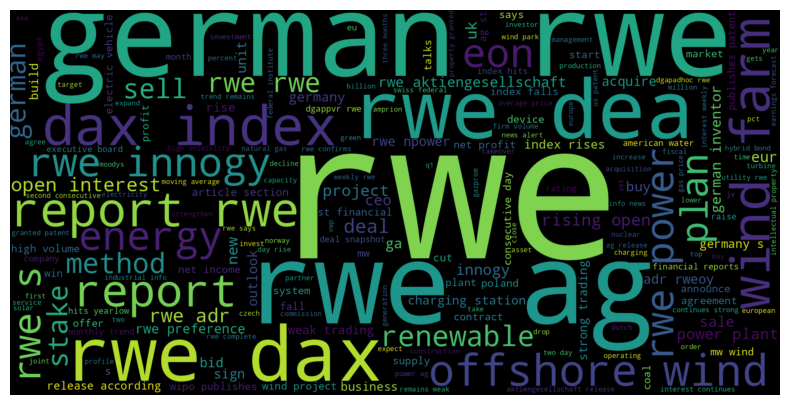

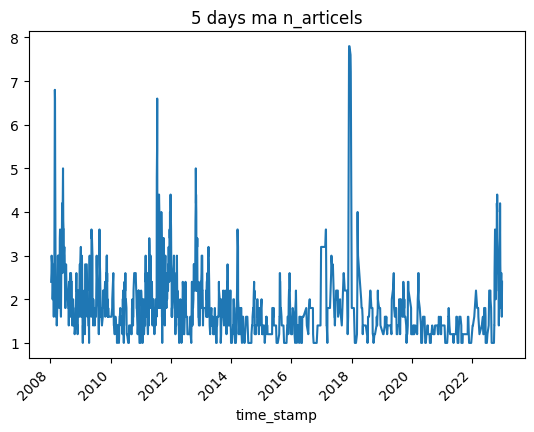

In [5]:
display(articles)

articles_string = articles['title'].to_list()
articles_string = ' '.join(articles_string)
articles_string = articles_string.lower()
articles_string = articles_string.translate(str.maketrans('', '', punctuation))
articles_string = ' '.join(articles_string.split())

wordcloud = WordCloud(width=2000, height=1000)
wordcloud.generate(articles_string)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

articles.groupby('time_stamp').size().rolling(5).mean().plot(kind='line',title='5 days ma n_articels')
plt.xticks(rotation = 45)
plt.show()

# Topic Modeling

In [6]:
def create_topic_activity(doc_topic: pd.DataFrame, docs: pd.DataFrame) -> pd.DataFrame:
    # insert time_stamp
    doc_topic['time_stamp'] = pd.to_datetime(docs['time_stamp'])

    # sum up news by date and company
    doc_topic['time_stamp'] = doc_topic['time_stamp'].dt.date
    count = doc_topic.groupby('time_stamp').size() + 0.0001
    topic_activity = doc_topic.groupby(['time_stamp']).sum()
    #topic_activity = topic_activity.div(count, axis=0)
    topic_activity['count'] = count

    # insert 0 for days with no news
    topic_activity.index = pd.to_datetime(topic_activity.index)
    topic_activity = topic_activity.asfreq('D', fill_value=0)

    # drop weekends
    topic_activity = topic_activity[topic_activity.index.get_level_values('time_stamp').dayofweek < 5]

    # add random validation topic
    #np.random.seed(random_state)
    topic_activity['topic_val'] = np.random.normal(
        scale=0.05,
        loc=-0.05,
        size=len(topic_activity),
    ) * topic_activity.max().max()
    topic_activity['topic_val'] = topic_activity['topic_val'].clip(lower=0).round(0)

    # compute moving average
    #topic_activity = topic_activity.ewm(halflife=5).mean()
    
    topic_activity.plot(
        kind='line',
        title='Topic Activity',
        subplots=True,
        figsize=(15, 10)
    )
    plt.tight_layout()
    plt.show()
    
    return topic_activity

## LDA

In [7]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


### Data preparation

In [8]:
%%time
lda_vectorizer = CountVectorizer(
    preprocessor=preprocessor,
    tokenizer=tokenizer,
    max_df=0.1,
    min_df=2,
    ngram_range=(1,2)
)

X = lda_vectorizer.fit_transform(articles['title'])
lda_tokens = articles['title'].apply(lda_vectorizer.build_analyzer()).to_list()

print(f'n_articels: {X.shape[0]}')
print(f'n_features (words/ngrams): {X.shape[1]}')

n_articels: 3127
n_features (words/ngrams): 4411
CPU times: user 5.08 s, sys: 229 ms, total: 5.31 s
Wall time: 5.33 s


### Evaluation

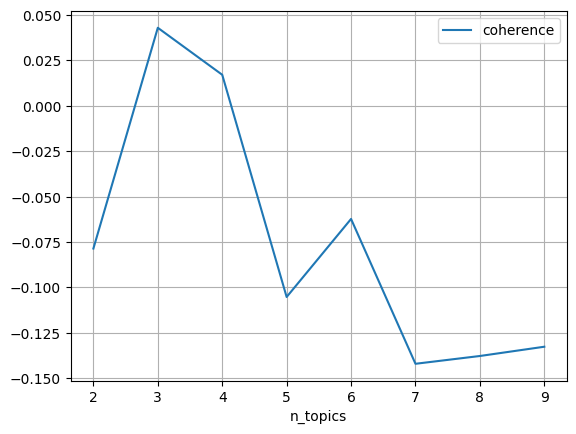

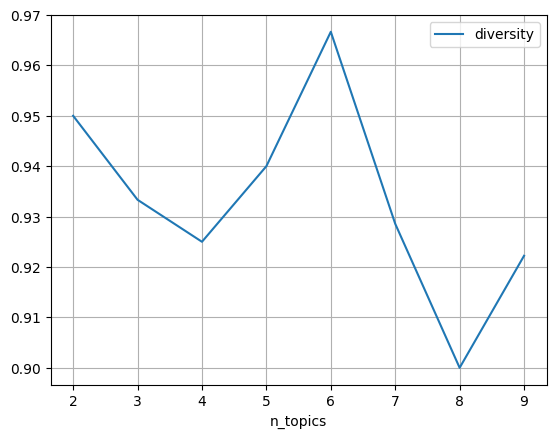

CPU times: user 972 ms, sys: 503 ms, total: 1.48 s
Wall time: 20.2 s


In [14]:
%%time
def compute_metrics(topic_coherence, t):
    # train lda
    lda = LatentDirichletAllocation(
        n_components=t,
        doc_topic_prior=None,
        topic_word_prior=None,
        learning_method='online',
        random_state=random_state,
    )
    lda.fit(X)

    # compute top words in topic
    topic_word = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
    topic_word = pd.DataFrame(
        topic_word,
        index=[f'topic_{i}' for i in range(1, topic_word.shape[0]+1)],
        columns=lda_vectorizer.get_feature_names()
    )
    topic_words = list()
    for topic in topic_word.index:
        topic_desc = list(topic_word.sort_values(topic, axis=1, ascending=False).loc[[topic], :].columns)
        topic_words.append(topic_desc[:10])
    
    # Evaluate
    coherence_model = CoherenceModel(
        topics=topic_words, 
        texts=lda_tokens, 
        dictionary=dictionary, 
        topn=10,
        coherence='c_npmi'
    )
    coherence = coherence_model.get_coherence()

    metric = TopicDiversity(topk=10)
    diversity = metric.score({'topics': topic_words})
    
    # append to shared list
    topic_coherence.append([t, coherence, diversity])

    
dictionary = corpora.Dictionary(lda_tokens)
# test hyper params
with Manager() as manager:
    topic_coherence = manager.list()
    processes = []
    max_topics = 10
    for t in range(2, max_topics):
        p = Process(target=compute_metrics, args=(topic_coherence, t))
        p.start()
        processes.append(p)
    for p in processes:
        p.join()
        
    topic_coherence = list(topic_coherence)

# plot
topic_coherence = pd.DataFrame(data=topic_coherence, columns=['n_topics', 'coherence', 'diversity'])
topic_coherence.sort_values('n_topics').plot(x='n_topics', y=['coherence'], grid=True)
plt.show()

topic_coherence.sort_values('n_topics').plot(x='n_topics', y=['diversity'], grid=True)
plt.show()


### Training

In [9]:
%%time
lda_model = LatentDirichletAllocation(
    n_components=5,
    doc_topic_prior=None,
    topic_word_prior=None,
    learning_method='online',
    random_state=random_state,
)
lda_model.fit(X)

CPU times: user 3.34 s, sys: 16.5 ms, total: 3.36 s
Wall time: 3.35 s


LatentDirichletAllocation(learning_method='online', n_components=5,
                          random_state=1)

### Results

In [10]:
#pyLDAvis.sklearn.prepare(lda_model, X, lda_vectorizer)

In [11]:
# prepare doc topic distribution
lda_doc_topic = lda_model.transform(X)
lda_doc_topic = pd.DataFrame(
    lda_doc_topic,
    columns=[f'topic_{i}' for i in range(1, lda_doc_topic.shape[1]+1)]
)
display(lda_doc_topic)

# calculate topic distribution
topic_size = (lda_doc_topic.sum() / len(lda_doc_topic)).to_frame().transpose()
display(topic_size)

# prepare topic word distribution
topic_word = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
topic_word = pd.DataFrame(
    topic_word,
    index=[f'topic_{i}' for i in range(1, topic_word.shape[0]+1)],
    columns=lda_vectorizer.get_feature_names()
).round(5)

# display topics
lda_topics = dict()
for topic in topic_word.index:
    lda_topics[topic] = list(topic_word.sort_values(topic, axis=1, ascending=False).loc[[topic], :].iloc[:, :5].columns)
    #display(topic_word.sort_values(topic, axis=1, ascending=False).loc[[topic], :].iloc[:, :10])

lda_topics = pd.DataFrame(lda_topics).transpose()
display(lda_topics)

,topic_1,topic_2,topic_3,topic_4,topic_5
0,0.012694,0.012501,0.012647,0.012542,0.949617
1,0.020041,0.020072,0.919509,0.020378,0.020000
2,0.017118,0.016667,0.016667,0.016871,0.932677
3,0.008000,0.008000,0.528497,0.008224,0.447279
4,0.699893,0.033348,0.033335,0.033356,0.200068
...,...,...,...,...,...
3913,0.012528,0.949881,0.012521,0.012528,0.012542
3914,0.100331,0.100001,0.100001,0.599667,0.100001
3915,0.733320,0.066670,0.066670,0.066670,0.066670
3916,0.724954,0.018182,0.018291,0.018210,0.220363


,topic_1,topic_2,topic_3,topic_4,topic_5
0,0.29575,0.180942,0.147277,0.178121,0.197909


,0,1,2,3,4
topic_1,report,dea,gas,stake,sell
topic_2,profit,outlook,price,net,energy
topic_3,board,accord,release,english,article
topic_4,rise,eon,interest,open,index
topic_5,power,patent,farm,wind farm,method


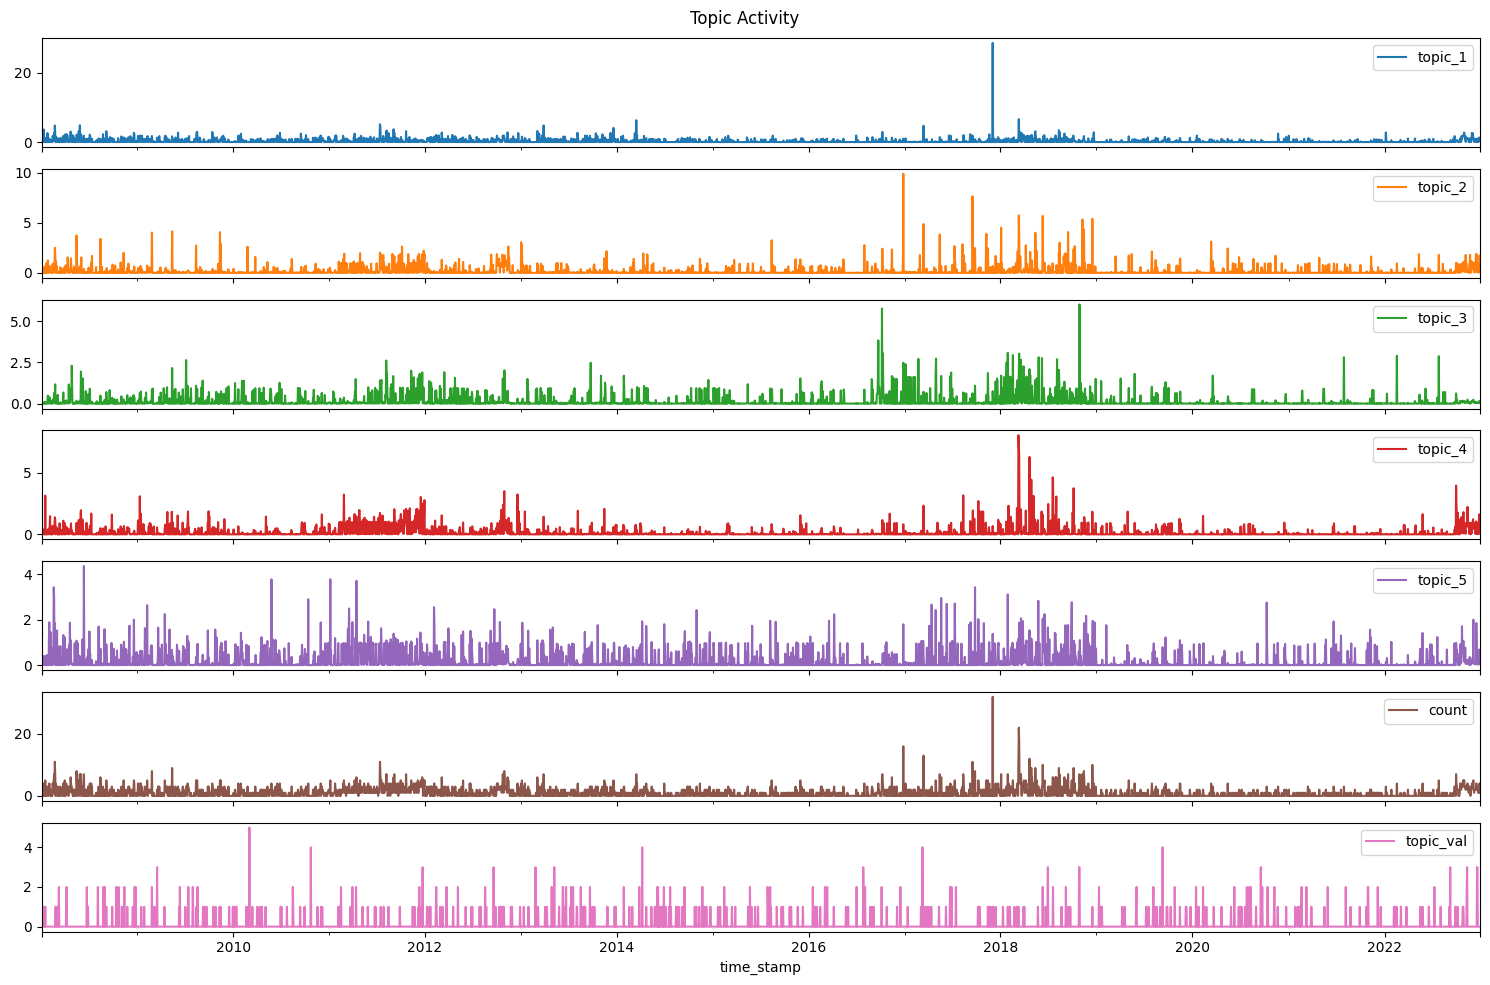

In [12]:
lda_topic_activity = create_topic_activity(lda_doc_topic, articles)

# safe to csv
lda_topic_activity.to_csv('data/rwe_lda_topic_activity.csv', sep=';')

## BERT Topic

In [10]:
from bertopic import BERTopic

2023-03-19 22:23:52.881340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/graph_objs/__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/graph_objs/__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/graph_objs/__init__.py:288: DeprecationWarn

### Data preparation

In [11]:
bert_vectorizer = CountVectorizer(
    preprocessor=preprocessor,
    tokenizer=tokenizer,
    ngram_range=(1, 2)
)

bert_dtm = bert_vectorizer.fit_transform(articles['title'])

### Evaluation

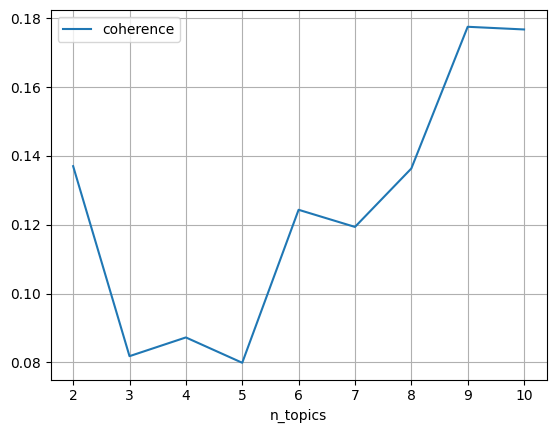

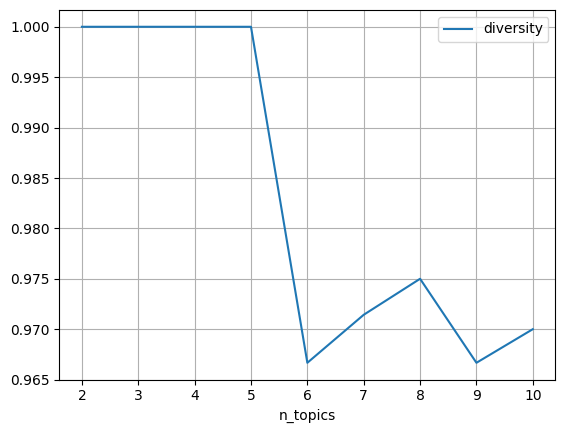

CPU times: user 12min 12s, sys: 26.8 s, total: 12min 39s
Wall time: 3min 44s


In [15]:
%%time
def compute_coherence_bertopic(topic_coherence, t):
    # reduce topics
    bertopic.reduce_topics(articles['title'], t)
    topics, probs = bertopic.transform(articles['title'])
    
    # Extract features for Topic Coherence evaluation
    topic_words = [[words for words, _ in bertopic.get_topic(topic)] for topic in range(len(set(topics))-1)]

    # Evaluate
    coherence_model = CoherenceModel(
        topics=topic_words, 
        texts=bert_tokens, 
        dictionary=dictionary, 
        topn=10,
        coherence='c_npmi'
    )
    coherence = coherence_model.get_coherence()

    metric = TopicDiversity(topk=10)
    diversity = metric.score({'topics': topic_words})
    
    # append to shared list
    topic_coherence.append([t, coherence, diversity])


os.environ["TOKENIZERS_PARALLELISM"] = 'false'
# train bertopic
bertopic = BERTopic(
    vectorizer_model=bert_vectorizer,
    language='english',
    calculate_probabilities=True,
    verbose=False
)
bertopic.fit(articles['title'])

# build bert tokens and dictonary
bert_tokens = articles['title'].apply(bertopic.vectorizer_model.build_analyzer()).to_list()
dictionary = corpora.Dictionary(bert_tokens)

# find optimal number of topics
topic_coherence = list()
max_topics = 10
for t in range(max_topics, 1, -1):
    compute_coherence_bertopic(topic_coherence, t)
os.environ["TOKENIZERS_PARALLELISM"] = 'true'

# plot
topic_coherence = pd.DataFrame(data=topic_coherence, columns=['n_topics', 'coherence', 'diversity'])
topic_coherence.sort_values('n_topics').plot(x='n_topics', y=['coherence'], grid=True)
plt.show()

topic_coherence.sort_values('n_topics').plot(x='n_topics', y=['diversity'], grid=True)
plt.show()


### Training

In [96]:
%%time
bert_model = BERTopic(
    nr_topics=5,
    vectorizer_model=bert_vectorizer,
    language='english',
    calculate_probabilities=True,
    verbose=False
)

bert_model.fit(articles['title'])

topics, probs = bert_model.transform(articles['title'])

topics = bert_model.reduce_outliers(
    articles['title'], topics,
    strategy='embeddings',
    probabilities=probs,
    threshold=0.2
)

bert_doc_topic = pd.DataFrame(
    columns=['topic'],
    data=topics,
    dtype='object'
)
bert_doc_topic = pd.get_dummies(bert_doc_topic)
bert_doc_topic.columns = bert_model.get_topic_info()['Name'].values

CPU times: user 3min 2s, sys: 8.79 s, total: 3min 11s
Wall time: 35.3 s


### Results

In [97]:
display(bert_model.get_topic_info())

pd.DataFrame(
    columns=['topic'],
    data=topics,
    dtype='object'
).groupby('topic').size()

,Topic,Count,Name
0,-1,1816,-1_german_report_power_energy
1,0,360,0_wind_farm_wind farm_offshore
2,1,344,1_rise_index_dax index_dax
3,2,323,2_profit_net_report_outlook
4,3,157,3_patent_method_charge_inventor
5,4,127,4_dea_gas_egypt_field


topic
-1    734
 0    566
 1    384
 2    915
 3    245
 4    283
dtype: int64

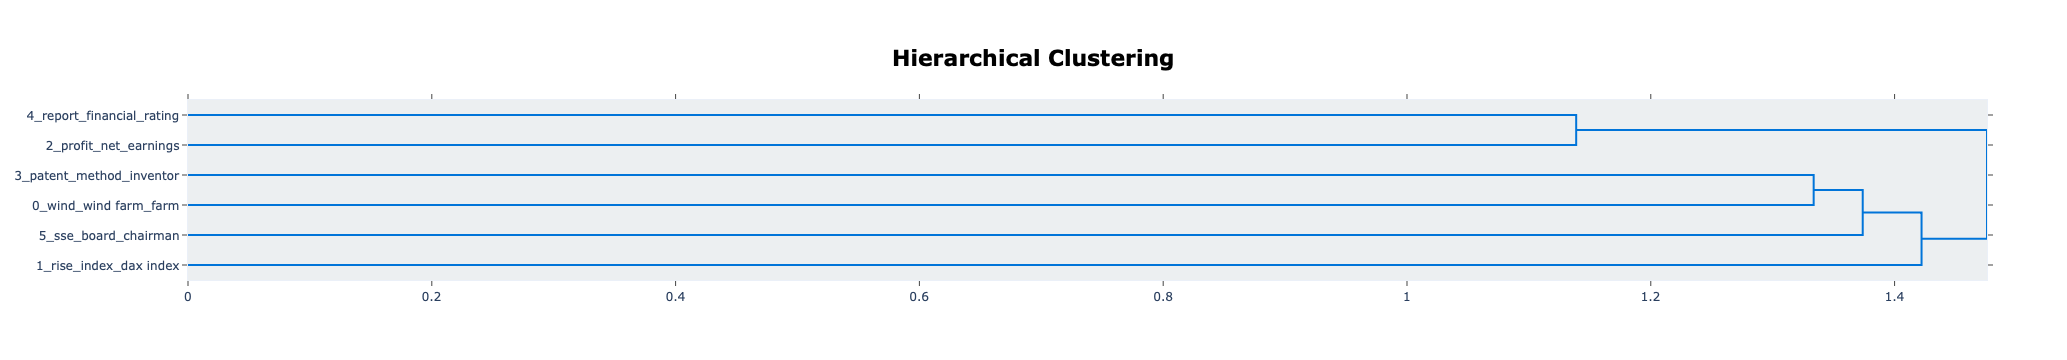

In [59]:
bert_model.visualize_hierarchy()

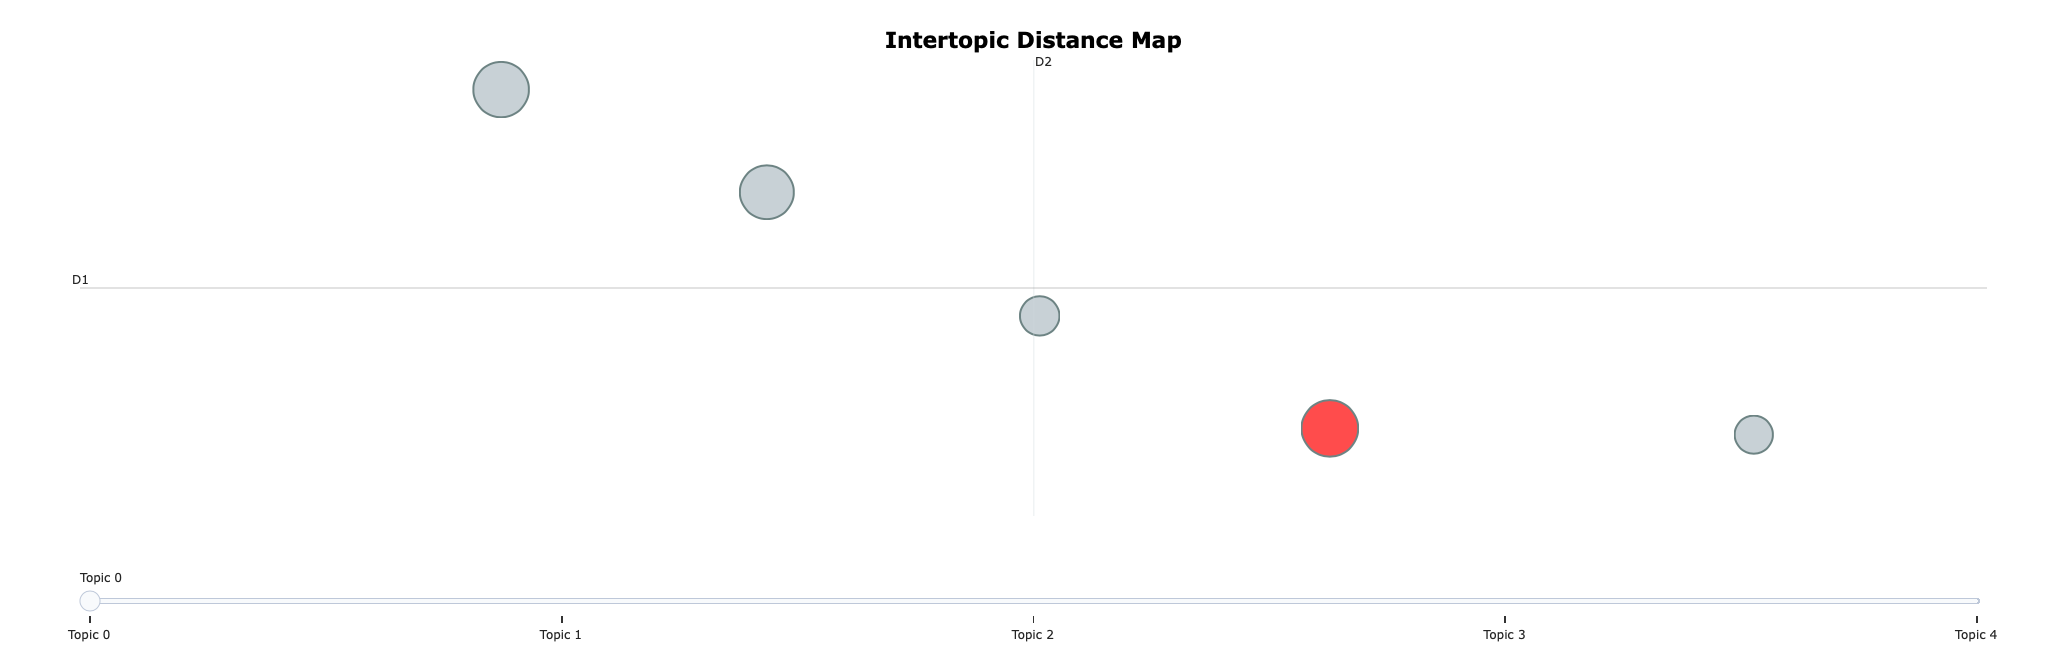

In [74]:
bert_model.visualize_topics()

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



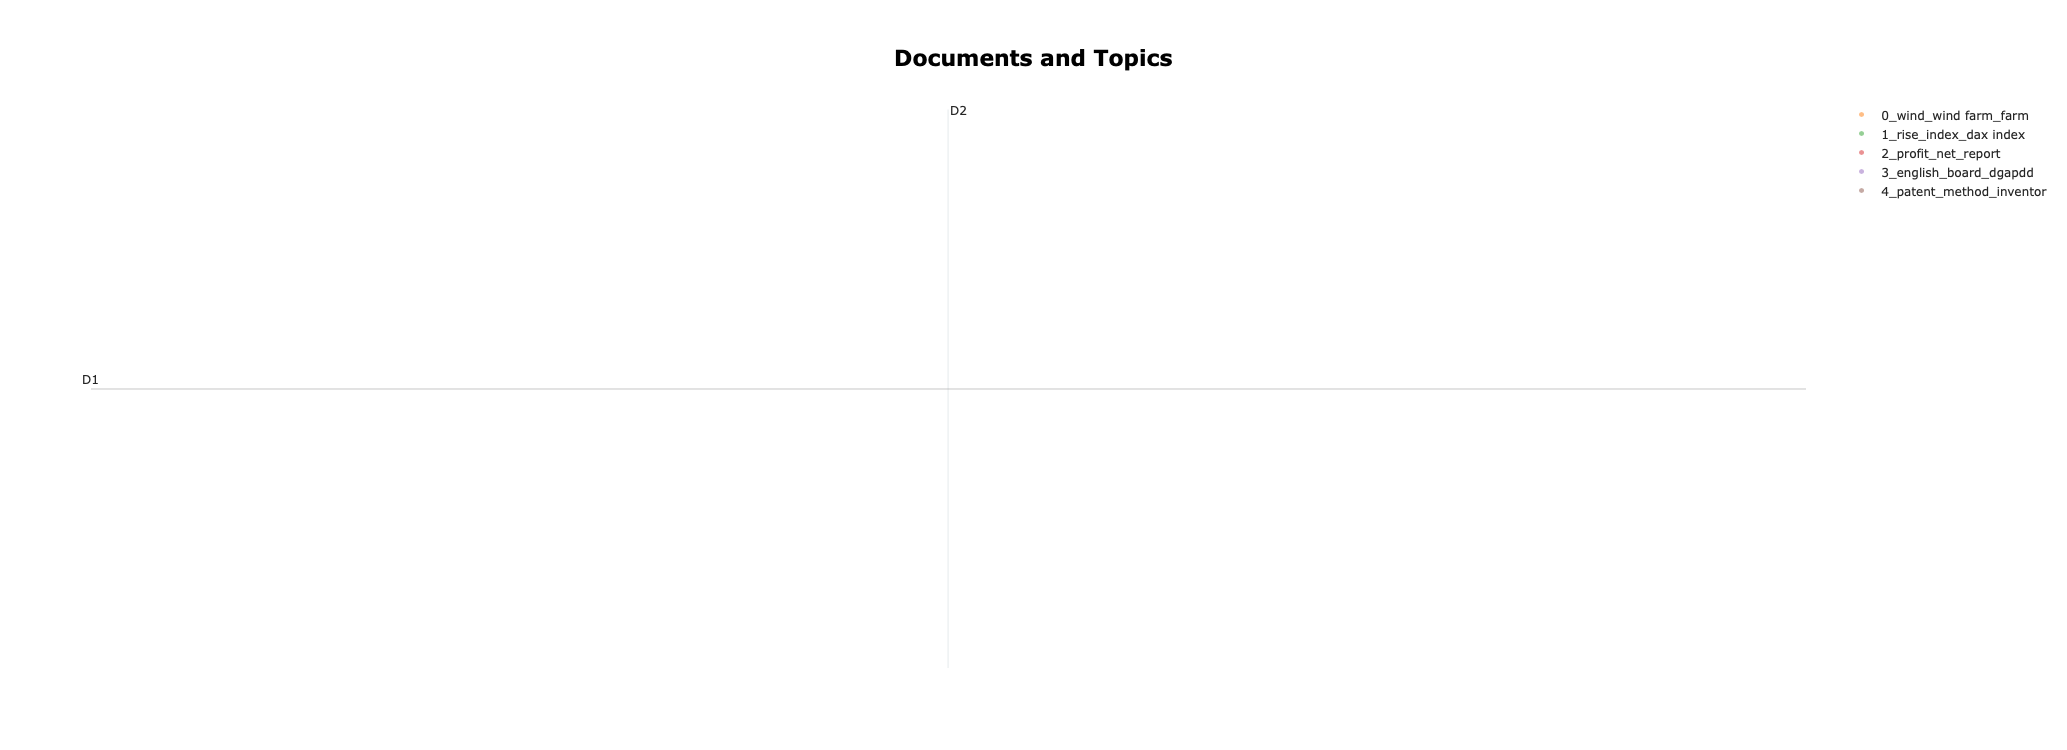

In [19]:
bert_model.visualize_documents(articles['title'])

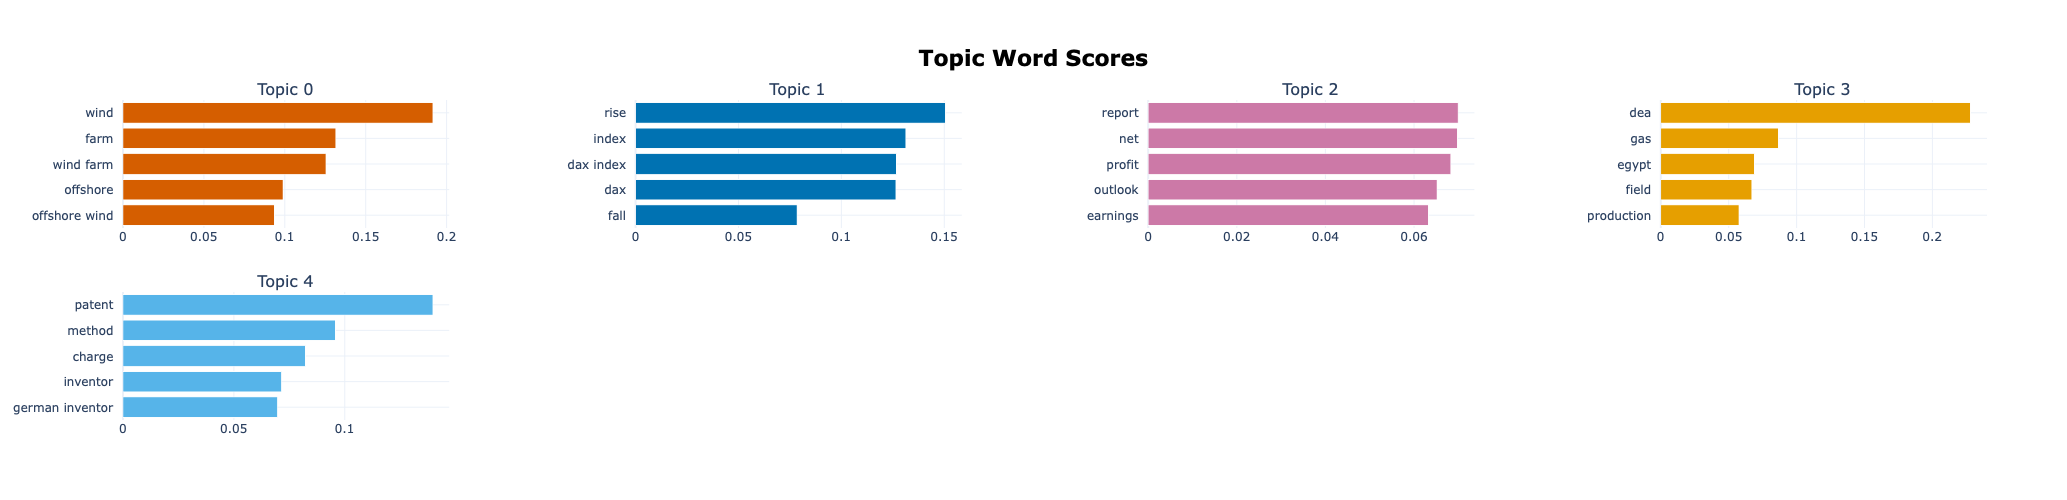

In [76]:
bert_model.visualize_barchart()

In [73]:
doc_top_assignment = dict(sorted(bert_model.get_representative_docs().items()))
keys = list(doc_top_assignment.keys())

for key in keys:
    doc_top_assignment[bert_model.get_topic_info().iloc[int(key)+1, 2]] = doc_top_assignment[key][:5]
    del doc_top_assignment[key]
    
display(doc_top_assignment)

{'0_wind_farm_wind farm_offshore': ['RENEWABLES - German RWE Innogy Acquires 300 MW Wind Farm Projects in Hungary',
  'RWE npower renewables gets go-ahead for 18-MW wind project',
  'RWE Innogy opens third onshore wind park in Poland',
  'RWE Renewables to sell power from planned Texas solar farm to Constellation',
  'RWE Renewables to build 2 solar farms in Spain'],
 '1_rise_index_dax index_dax': ['RWE [ DAX index] rises in strong trading with rising open interest, continues strong weekly and monthly trend',
  'RWE [ DAX index] rises in strong trading with rising open interest, continues strong monthly trend',
  'RWE [ DAX index] rises in strong trading with rising open interest, continues strong monthly trend',
  'RWE preference strengthens on low volume',
  'RWE preference dips on low volume'],
 '2_report_net_profit_outlook': ['RWE AG ST Financial Reports: Report on the first quarter of 2012',
  'RWE AG ST Financial Reports: Report on the first half of 2013',
  'RWE AG ST Financial 

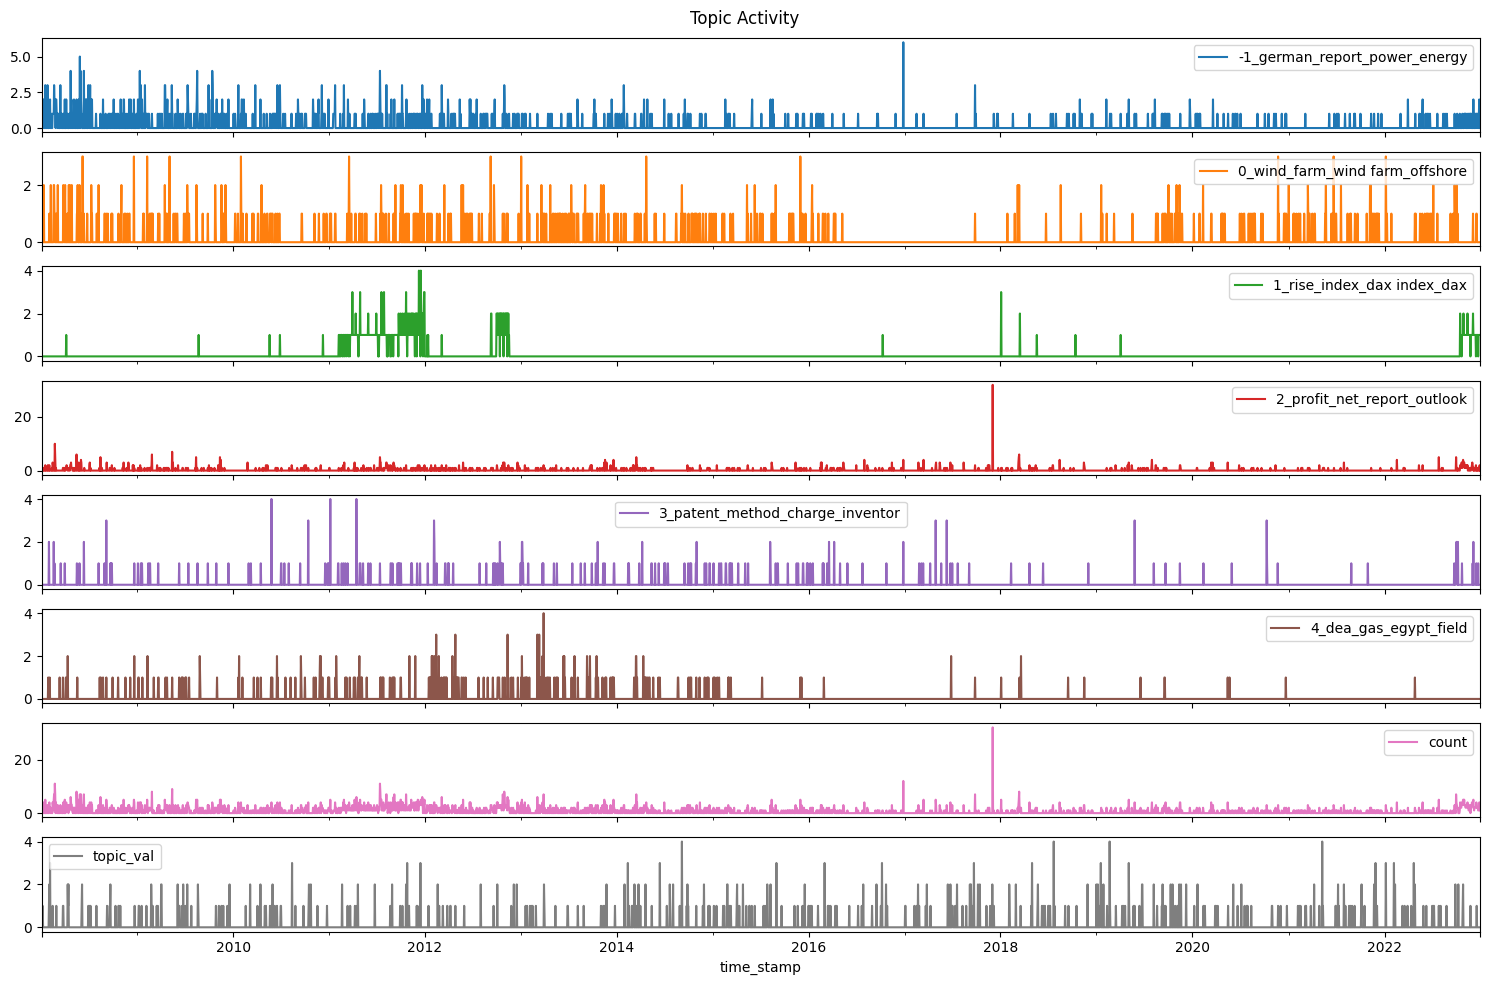

In [100]:
# Topic activity for Baseline
bert_topic_activity = create_topic_activity(bert_doc_topic, articles)
#bert_topic_activity = bert_topic_activity[bert_topic_activity.index < '2016-01-01']

# safe to csv
bert_topic_activity.to_csv('data/rwe_bert_topic_activity.csv', sep=';')

# Dataset for Advanced Approach
dataset = articles.copy()
dataset['topic'] = topics
dataset.to_csv('data/rwe_news_dataset.csv', sep=';', index=False)